# Import Statements


In [3]:
###############REQUIRED FOR PICASSO-LITE##################
import numpy as np
import scipy.optimize as so
from sklearn.preprocessing import KBinsDiscretizer
import random 
import copy
##########################################################
import os
import matplotlib.pyplot as plt
from PIL import Image

## Some useful function definitions
### Load n-channel tiff stacks. 
#### If the files are very large (stitched images) adjust the PIL maximum image size allowed. 


In [51]:
def load_nchan_image(filepath):
    imchans_list = []
    if os.path.exists(filepath):
        try:
            im = Image.open(filepath)
            num_chans = getattr(im, "n_frames", 1)
            im.load()#PIL loads channel zero when .open is called initially
            print(f"This is a {num_chans} - channel file.")
            
            data = np.array(im)

            imchans_list.append(data)
            for i in np.arange(1,num_chans):
         
                im.seek(i)#move to channel i 
                im.load()#get the pixel-level data
                data = np.array(im)#convert to numpy array   
  
                imchans_list.append(data)

            return num_chans, imchans_list
        except Exception as e:
            print(f"Warning: Failed to load the image from {filepath}. Error {str(e)}")
            return [],[]
    
    else:
        raise FileNotFoundError(f"The file {filepath} does not exist")
        return [],[]
    

### A function to create montages from tiff stacks imported as numpy arrays

In [47]:
def make_montage(im_stack, titles = [], outpath = [], numcols = 5, numrows = 1,lower_pct = 1, upper_pct = 99, show_montage = False):
    #this function makes a montage of the input image stack, with the titles provided

    n_color = im_stack.shape[0]
    col = numcols
    if col > n_color:
        col = n_color
    
    
    num_rows = np.floor(np.around(n_color/col))

    remainder = np.remainder(n_color,num_rows)

    if n_color > num_rows*col:
        num_rows += 1
    

    ff,aa = plt.subplots(np.int_(num_rows),np.int_(col),figsize=(3*col,3*num_rows))
    aa = aa.ravel()

    
    for idx,ax in enumerate(aa):
        if idx < n_color:
        
            single_slice = np.copy(im_stack[idx,:])
       
        
        
            im_max = np.nanpercentile(single_slice,upper_pct)
            im_min = np.nanpercentile(single_slice,lower_pct)
            
        
        
            ax.imshow(single_slice,vmin = im_min, vmax = im_max,cmap = 'gray',interpolation=None)
            if len(titles) > 0:
                ax.set_title(titles[idx],fontsize = 20)
            else:
                ax.set_title(str(idx),fontsize = 20)
            
            ax.axis('off')
        else:
            ax.axis("off")

    plt.subplots_adjust(wspace=0.001)
    
    if outpath:
        plt.savefig(outpath,bbox_inches='tight', dpi=300)
        
    if not show_montage:
        plt.close()

This is a 3 - channel file.


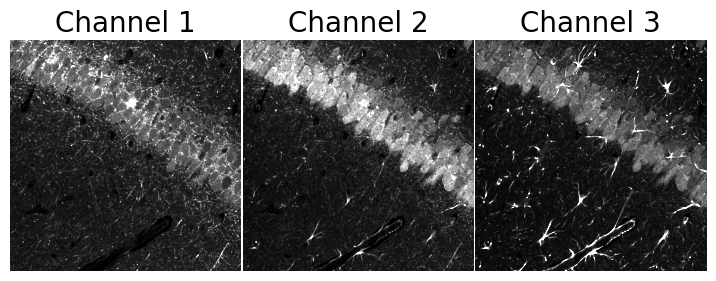

In [49]:
#load the 3 channel laser scanning confocal tiff file provided by the PICASSO method authors
filename = '3color_data.tif'
filepath = os.path.join("D:/images/", filename)
num_chans, test = load_nchan_image(filepath)
test = np.asarray(test)
make_montage(test, titles = ['Channel 1','Channel 2','Channel 3'],
             outpath = "D:/images/raw_composite.png", numcols = 3, numrows = 1,lower_pct = 1, upper_pct = 99, show_montage = True)


# PICASSO-LITE Class Definition

In [ ]:




class MI_unmixer: 
    
    def __init__(self, n_color=0, maxIter = 8, learn_rate = 0.65, qQ = 200,qN = 100):
        
        self.n_color = n_color
        self.maxIter = maxIter#maximum number of iterations
        self.learn_rate = learn_rate#learning rate for unmixing
        self.qQ = qQ#number of bins for 16bit range quantization
        self.qN = qN#number of bins for 2d histograms
        self.ops_list = []#unmixing operations list. each entry in the list is one unmixing step. 
        self.encoder = KBinsDiscretizer(n_bins=qQ, encode="ordinal", strategy="uniform", random_state=42)#encoder for unmixing
    
    def mi_normalize(self,hyperspec_img):
        #[0:max] normalizeation of each channel, if using pseudochannels, these should be created prior to normalization.
        #background model should be subracted before normalization
        
        
        nch,nrow,ncol = hyperspec_img.shape
        
            
        norm_data = np.zeros((hyperspec_img.shape))
        
        for chn in np.arange(nch):
            
            single_img = hyperspec_img[chn,:,:] 
            
                
            chmax = np.nanpercentile(single_img.flatten(),100)
               
            norm_img= (single_img)/(chmax)
            norm_img[norm_img < 0 ] = 0
            
            
            norm_data[chn,:,:] = norm_img
        return norm_data 
    
    def objective(self,x,XY):#function of optimization for MI-based unmixing
        np.random.seed(42)
        
        X_j = XY[1,:]
        X_i = XY[0,:]
    
        nr = np.shape(X_j)[0]
        rand_img = np.random.rand((nr))
    
        total_pix = len(X_j)

        scaled_diff = X_i - x*X_j
        num_neg = np.sum([scaled_diff < 0])#the cost function to minimize includes the number of negative pixels
    
        neg_img = np.copy(scaled_diff)
    
    
        frac_neg = num_neg/total_pix
    
        neg_img[neg_img > 0] = 0.01*rand_img[neg_img > 0]#0
        neg_img = np.abs(neg_img)
    
        diff_mi = self.mutual_info(X_j, scaled_diff)
        neg_mi = self.mutual_info(X_j,neg_img)
    
    
        return diff_mi + neg_mi + frac_neg #+ x**2
    
    def mutual_info(self, im1, im2):
        qN = self.qN
        hist_2d, x_edges, y_edges = np.histogram2d(im1, im2, bins=qN)
        #print(np.max(im1))
        #print(np.max(im2))
        # Convert bins counts to probability values
        pxy = hist_2d /float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1) # marginal for x over y
        py = np.sum(pxy, axis=0) # marginal for y over x
        px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    
        # Now we can do the calculation using the pxy, px_py 2D arrays
        nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
        #print(nzs.shape)
        mutual_info = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    
        return mutual_info
    
    def quantize(self, img):
        qQuant = self.qQ
        #img is image data: nrow x mcol image. single slice. 
        #qQuant is the number of bins
              
        compressed = np.zeros(img.shape)
        compressed = self.encoder.fit_transform(img.reshape(-1, 1)).reshape(img.shape)/(qQuant-1)
        
        return compressed
    
    def mi_datashaper(self,img_stack):
        #function to shape hyperspectral image cubes (l-channels x m rows x n columns) into l-channels x m*n columns
        reshaped = np.reshape(img_stack,(img_stack.shape[0],-1))
        
        return reshaped
    
    def mi_fit(self, im_stack):
        np.random.seed(42)
        #im_stack is the m-channel x n pixel mixed image set ->reshape c*x*y image cube to 2D
        n_color, npix = np.shape(im_stack) #number of channels and pixels in the hyperspectral image
        
        self.n_color = n_color
        learn_rate = self.learn_rate
        
        X = im_stack
        
        
        bound = [(0, 1)] #set positive contraints for alpha values

        num_iter = 0#number iterations
        
        alpha_mat = 0.1*np.random.rand(n_color,n_color) +0.1 #matrix to hold the unmixing coefficients
        P = np.array(np.identity(n_color)) #matrix like alpha_mat but with negative signs in front of non-diagonal entries

        encoder = self.encoder#encoder for unmixing

        unmix_ops_list = np.zeros((self.maxIter,n_color,n_color)) #keep the unmixing matrix for each iteration
        
        #alpha_mat diagonals must == 1:
        
        alpha_mat[P==1] = 1
        
        beta_mat = np.zeros((n_color,n_color))
    
        while num_iter < self.maxIter:
            
            num_iter += 1
        
            
                
            rand_img = np.random.rand((npix))#used in optimization function
            print(num_iter)
            
            #normalize the data
            for color in np.arange(n_color):
                       
                temp = X[color,:]
                Xmax = np.nanpercentile(temp.flatten(),100)
                
                beta_mat[color,:] = Xmax
                
                XX = (X[color,:])/(Xmax)
                XX[XX<0] = 0

                X[color,:] = XX  
            
            Xq = self.quantize(X)
           
            for ch in range(P.shape[0]):
                #print(ch)
                for dy in range(P.shape[1]):
                
                    if ch != dy: #diagonals are == 1

                        Xj = Xq[dy,:]
                        Xi = Xq[ch,:]
                    
                        X_Y = np.zeros((2,Xj.shape[0]))
                        X_Y[0,:] = Xi
                        X_Y[1,:] = Xj
           
                        alpha = alpha_mat[ch,dy]
                        
                        results = so.minimize(self.objective, x0=alpha, args=X_Y, bounds=bound,method='Powell',options = {'xtol':0.001,'ftol':0.001,'maxiter':5000}) #x0 must have ndims = 1
                        
                        alpha_mat[ch,dy] = results.x#
                        P[ch,dy] = (-1)*learn_rate*alpha_mat[ch,dy]

            #hold the unmixing iteration array
            unmix_ops_list[num_iter-1,:,:] = P
            
            #perform the  unmixing
            
            BP = np.multiply(beta_mat,P)
            
            X = np.matmul(BP,X) 
            X[X<0] = 0
        
            
                
                      
        self.ops_list = unmix_ops_list
   
        return self
    
    def mi_transform(self,im_stack):
        #im_stack is the m-channel x n pixel mixed image set ->reshape c,x,y image cube to 2D
        if len(self.ops_list) > 0:
            X = im_stack
            beta_mat = np.zeros((self.n_color,self.n_color))
            for operation in range(len(self.ops_list)):
                
                P = self.ops_list[operation]
                n_color = P.shape[0]
                #normalize the data
                for color in np.arange(n_color):
                       
                    temp = X[color,:]
                    Xmax = np.nanpercentile(temp.flatten(),100)
                
                    beta_mat[color,:] = Xmax
                
                    XX = (X[color,:])/(Xmax)
                    XX[XX<0] = 0

                    X[color,:] = XX  
            
                               
                BP = np.multiply(beta_mat,P)
                X = np.matmul(BP,X) 
                X[X<0] = 0
                   
             
            return X                       
        else:
            print('error: model not trained on data')
            return []
        